# Learning Soft Constraints using Apprenticeship Learning

## General Setup and Imports

Propagate code changes into notebook

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%matplotlib inline

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

In [11]:
import max_ent.examples.grid_9_by_9 as G
from max_ent.gridworld import Directions
#%matplotlib notebook      commenting this out enables inline plotting
np.random.seed(123)

## Gridworld Setup

The following function sets up the gridworld environment. The gridworld is a 2D grid with a start and goal state. The fig object is also returned now as the last parameter, and if this is saved you can view the images of the world. 

In [12]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=8, vmin=-50, vmax=10):
    n_cfg = G.config_world(blue, green, cs, ca, cc, goal)
    n = n_cfg.mdp

    # Generate demonstrations and plot the world
    demo = G.generate_trajectories(n.world, n.reward, n.start, n.terminal)
    vmin = -50
    vmax = 10
    G.plot_world(title, n, n_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           demo, n_cfg.blue, n_cfg.green, vmin=vmin, vmax=vmax)
    return n, n_cfg, demo

### Nominal World

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10d159810>}


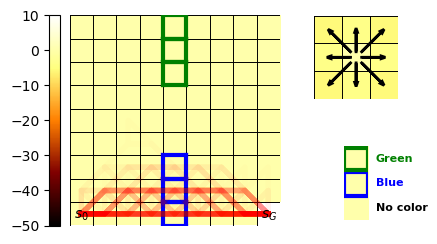

In [13]:
blue = [4, 13, 22]  # blue states
green = [58, 67, 76]  # green states

n, n_cfg, demo_n = create_world('Nominal', blue, green)

### Constrained World Creation

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10d159810>}


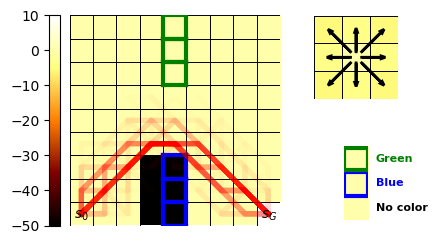

In [14]:
cs = [3, 4, 12, 13, 21, 22]  # constrained states
ca = []  # constrained actions
cc = []  # constrained colors

c, c_cfg, demo_c = create_world('Constrained', blue, green, cs, ca, cc)

## Algorithm

### Algorithm Specific Imports

In [20]:
import max_ent.optim as O
from max_ent.algorithms import rl as RL
from numpy.linalg import norm
import math
import max_ent.gridworld.trajectory as T

### Helper Functions

In [ ]:
def fe_from_trajectories(features, trajectories, discount):
    """
    Compute the empirical feature expectations from a set of trajectories.

    param features: feature matrix of shape (n_states, n_actions, n_states, n_features)
    param trajectories: list of trajectory instances containing array 
                        of (state, action, next_state) tuples
    param discount: discount factor

    return: averaged discounted feature expectations
    """
    n_features = features.shape[-1]

    fe = np.zeros(n_features)

    for t in trajectories:
        time_step = 0
        for s, a, s_ in t.transitions():
            fe += features[s, a, s_, :] * discount ** time_step
            time_step += 1

    return fe / len(trajectories)

### Parameters

In [21]:
discount=0.95
clip_grad_at=10
lr=0.3
max_iter=500
burn_out=50
eps=1e-4
log=None
initial_omega=None
init = O.Constant(1e-6)
optim = O.ExpSga(lr=lr, clip_grad_at=clip_grad_at)

In [22]:
nominal_rewards = n.reward
world = c.world
terminal = c.terminal
trajectories = demo_c.trajectories
p_transition = world.p_transition
features = world.phi

In [29]:
trajectories[0]

Trajectory([(0, 2, 9), (9, 2, 18), (18, 1, 19), (19, 5, 29), (29, 1, 30), (30, 1, 31), (31, 7, 23), (23, 7, 14), (14, 1, 15), (15, 1, 16), (16, 7, 8)])

### Learning

First, initialize some variables and compute empirical variables.

In [24]:
n_states, n_actions, _, n_features = features.shape
features[terminal] = 0  #can't transition from a terminal state
nominal_rewards = np.array(nominal_rewards)  # nominal reward vector is already known


In [ ]:
mu_e = fe_from_trajectories(features, trajectories, discount)